## [Master en Data Science (UC-UIMP)] Introduction to R
### Practise: Building a weather generator
### Using R or Python (or both). Indicative examples provided in R

#### Introduction

Weather generators are computational models which generate (daily) synthetic series of random values simulating the distribution of a particular meteorological variable. Precipitation is the most popular example due to its mixed character: discrete (ocurrence: dry or wet) and continuous (rain amount for wet days). The discrete part is typically characterized by the frequency of wet/dry days (say, e.g. 0.53/0.47 in Santander), whereas the continuous is typically characterized by an exponential distribution defined by a rate parameter (you don't need to understand statistics for this practise! it is only about programming).

In this practice we will use the main control structures (conditionals and loops) and apply them to build a simple weather generator and create artificial precipitation amount series. To this aim we will use some functions which simulate (pseudo)random numbers from different families of distributions (uniform and exponential), which is a key task for several computational statistics problems (you will learn a lot more about this in the stastistics course).

## How does a precipitation time series look like?

In order to work with real data, we will use to files with daily information for two weather stations: Santander CMT (RR_STAID003922.txt) and Santander/Parayas (RR_STAID003923.txt). The former is located in the Santander regional center (close to el Faro de Cabo Mayor) and the latter is located in Santander airpot. Open one of the files with a text editor and see the structure: it has some lines with information (to be skipped) and then a header followed by number in columns (STAID: the code of the station; SOUI: the international code of the station; DATA: the day; RR: precipitation value; Q_RR: a quality control flat, 0: OK; 9: missing data).

In [9]:
# Loading libraries
library(ggplot2)

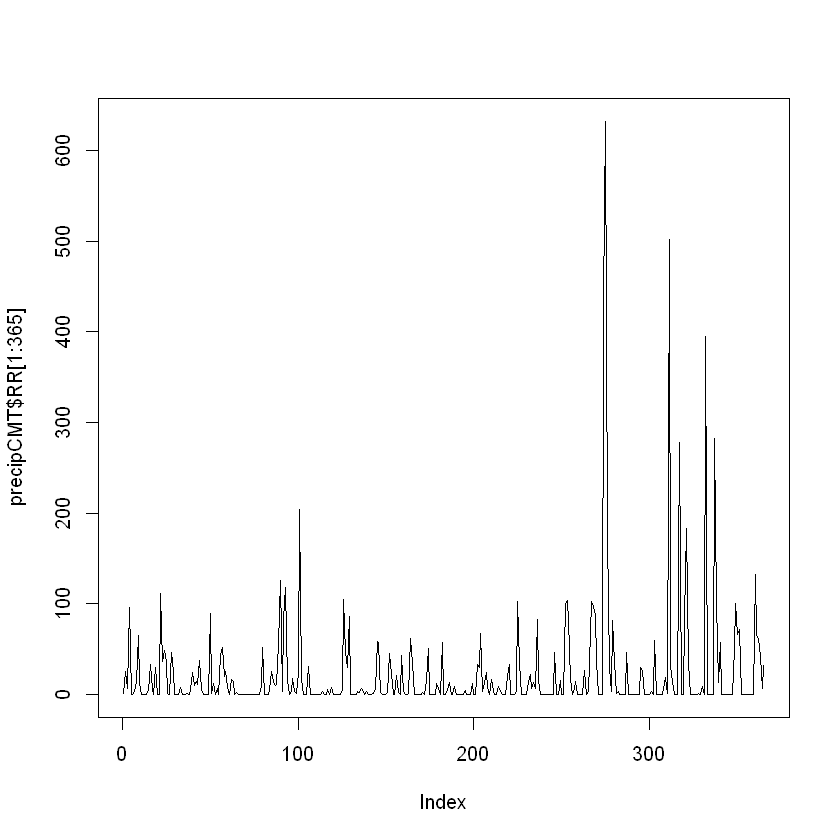

In [31]:
# Loading and ploting data for Santander CMT
precipCMT <- read.csv("RR_STAID003922.txt", skip = 20, header = T)
plot(precipCMT$RR[1:365], type = "l")    # first year

Now try to load the data for Parayas (in this case the series contains missing data characterized by -9999, you will see this when plotting). In both cases, the units of the data is "10*mm". You need to divide both series by 10 in order to get "mm" (litros por metro cuadrado). 

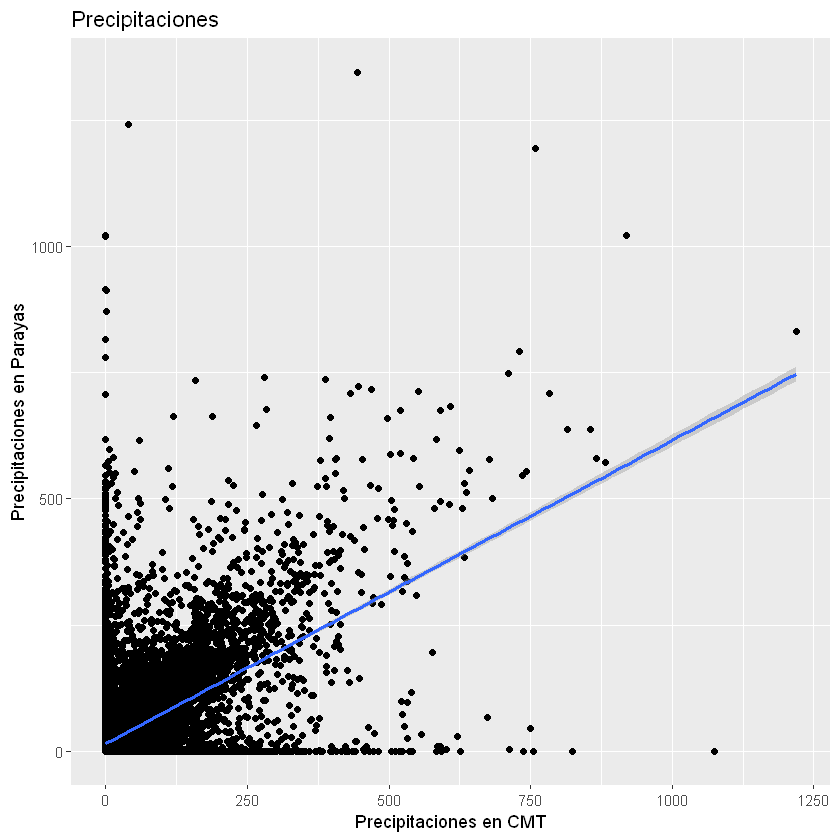

In [32]:
# Load the series for Parayas and remove missing data.
# Both series should be very similar. Compare them using e.g. 
# a scatter plot (points displayed along the diagonal if equal).

precipParayas <- read.csv("RR_STAID003923.txt", skip = 20, header = T)
precipParayas <- precipParayas[precipParayas$Q_RR != 9, ]

auxDF <- data.frame(CMR = tail(precipCMT$RR, nrow(precipParayas)),
                    Parayas = precipParayas$RR)
ggplot(auxDF) + geom_point(aes(x = CMR, y = Parayas)) +
    geom_smooth(method = "lm", aes(x = CMR, y = Parayas)) +
    xlab('Precipitaciones en CMT') + ylab('Precipitaciones en Parayas') +
    ggtitle('Precipitaciones')

In [50]:
# Compute basic statistics for both series:
# Frequency of wet days (this is the probability of rain)
summary(precipCMT$RR)
summary(precipParayas$RR)

probCMT <- sum(precipCMT$RR > 0) / nrow(precipCMT)
probParayas <- sum(precipParayas$RR > 0) / nrow(precipParayas)

# Transition probabilities (from dry to dry and from dry to wet)
# you may need to create a loop and using a conditional for this

transCMT <- as.integer(precipCMT$RR > 0) # 1 Wet    0 Dry
transParayas <- as.integer(precipParayas$RR > 0)

# CMT
transVec_CMT <- c(0, 0, 0, 0)
names(transVec_CMT) <- c('Dry|Dry', 'Dry|Wet', 'Wet|Wet', 'Wet|Dry')
for (i in 2:length(transCMT)) {
    
    if(transCMT[i - 1] == 1 & transCMT[i] == 0) {
        transVec_CMT['Dry|Wet'] <- transVec_CMT['Dry|Wet'] + 1
    } else if(transCMT[i - 1] == 1 & transCMT[i] == 1) {
        transVec_CMT['Wet|Wet'] <- transVec_CMT['Wet|Wet'] + 1
    } else if(transCMT[i - 1] == 0 & transCMT[i] == 1) {
        transVec_CMT['Wet|Dry'] <- transVec_CMT['Wet|Dry'] + 1
    } else if(transCMT[i - 1] == 0 & transCMT[i] == 0) {
        transVec_CMT['Dry|Dry'] <- transVec_CMT['Dry|Dry'] + 1
    }
    
}
transVec_CMT <- transVec_CMT / (length(transCMT) - 1)
        
transVec_CMT
    
# Parayas
transVec_Parayas <- c(0, 0, 0, 0)
names(transVec_Parayas) <- c('Dry|Dry', 'Dry|Wet', 'Wet|Wet', 'Wet|Dry')
for (i in 2:length(transParayas)) {
    
    if(transParayas[i - 1] == 1 & transParayas[i] == 0) {
        transVec_Parayas['Dry|Wet'] <- transVec_Parayas['Dry|Wet'] + 1
    } else if(transParayas[i - 1] == 1 & transParayas[i] == 1) {
        transVec_Parayas['Wet|Wet'] <- transVec_Parayas['Wet|Wet'] + 1
    } else if(transParayas[i - 1] == 0 & transParayas[i] == 1) {
        transVec_Parayas['Wet|Dry'] <- transVec_Parayas['Wet|Dry'] + 1
    } else if(transParayas[i - 1] == 0 & transParayas[i] == 0) {
        transVec_Parayas['Dry|Dry'] <- transVec_Parayas['Dry|Dry'] + 1
    }
    
}
transVec_Parayas <- transVec_Parayas / (length(transParayas) - 1)
        
transVec_Parayas

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   31.83   30.00 1262.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   33.89   30.00 1344.00 

Dry|Dry   Dry|Wet   Wet|Wet   Wet|Dry 
0.3765756 0.1586718 0.3061099 0.1586426

Dry|Dry   Dry|Wet   Wet|Wet   Wet|Dry 
0.3946647 0.1599717 0.2853920 0.1599717

## Generating precipitation occurrence (0/1 series)

We first consider the case of precipitation occurrence (o for dry days and 1 for wet days).  

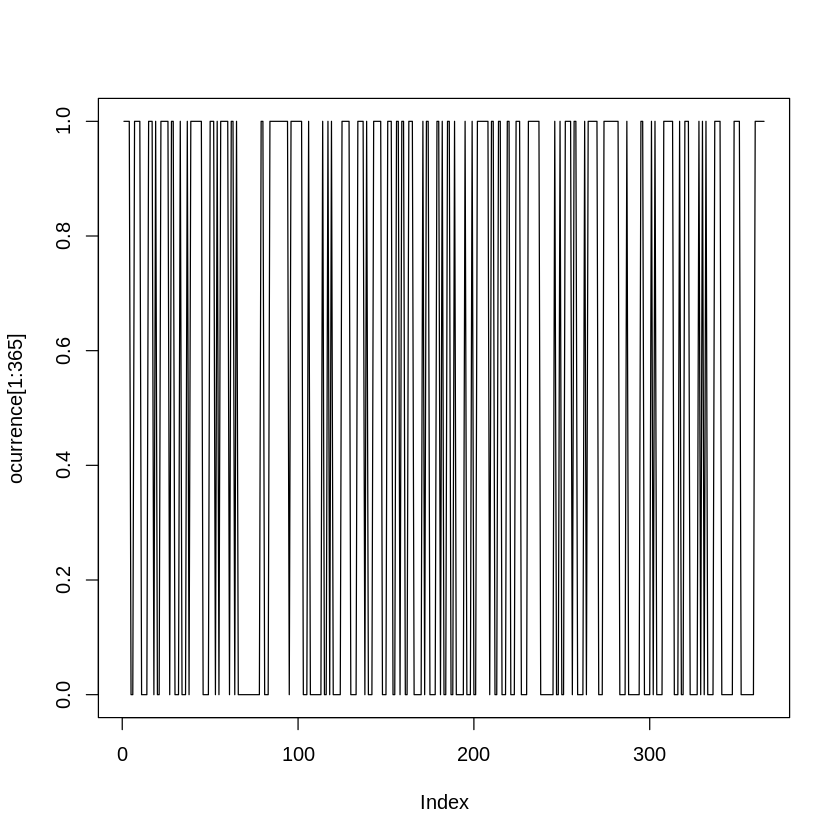

In [31]:
precip <- r1$RR / 10;
ocurrence <- as.integer(precip > 0);
plot(ocurrence[1:365], type="l")     # the first year

In order to generate a synthetic precipitation series for Santander we can use the function `runif` which generates random uniform numbers (between 0 and 1, which can be viewed as probabilities). Then, random numbers above the rain frequency for Santander can be coverted to one and numbers below to zero. 

In [26]:
? runif

# Obtain a series of 365 uniform numbers (between 0 and 1). 
# Use the frequency tresholds for Santander to convert to 0 or 1 values

# insert your code here

The series does not resemble the real one very much, since real precipitation is autocorrelated (sequences of zeros/ones), whereas the random numbers are not. Therefore, modify the code using the transition probabilities to generate rain ocurrence considering the transition probabilities. You may need to use a loop for this, computing ocurrence[i+1] based on the value of ocurrence[i].

In [29]:
# define a function with arguments for the transition probabilities
# and the number of simulated days and output the simulated series
# insert your code here

# plot the result (for a year)

Could you think of a more efficient way of implementing the above function?. Thy to avoid the use of loops by means of vectorized operations.

In [ ]:
# vectorized implementation
# insert your code here

## Simulating precipitation amount

The precipitation amount for the wet days (occurrence > 0) can be simulated using an exponential distribution. We need to fit a theoretical distribution to the observed in order to obtain the `rate` parameter. As an alternative, you can used instead the mean of the wet days precipitation amount (mean of precip values > 0). Then, we can use the `rexp` function to simulate random values with the obtained rate. 

and the precipitation amount for the wet days (occuDry == 0). To this aim, we need to fit a theoretical distribution to the observed data for each station. The two distributions most commonly used to simulate precipitation are the [Gamma](http://en.wikipedia.org/wiki/Gamma_distribution) and [Exponential](http://en.wikipedia.org/wiki/Exponential_distribution) distributions. We should load the library `MASS` and use the `fitdistr` function.

In [32]:
# Option 1: use the library MASS and use the fitdistr function.
library(MASS)   # you may need to install this package
? fitdistr      # use fitdistr to fit an exponential and obtain the rate.
# Option 2: estimate the rate as the mean of precip (for days with precip>0 only)
# Use only option 2 if running into trouble with option 1.

# Using the obtained rate, simulate 365 amount values and obtain the
# precipitation series multiplying the simulated occurrence and amount.
# 
# insert your code here
# 

ERROR: Error in library(MASS): there is no package called ‘MASS’


Now, we can gather all previous work on a single function to do the job.

In [ ]:
# define a function implementing the whole process and use it 
# to obtain series for Santander. 

# insert your code here